In [1]:
import os, sys
os.chdir("/home/charliecheng/caiyi/DexGraspNet2")
sys.path.append(os.getcwd())
import numpy as np
import torch
from PIL import Image
import scipy.io as scio
from types import SimpleNamespace
import plotly.graph_objects as go
from src.utils.pc import depth_image_to_point_cloud, transform_pc, get_workspace_mask
from src.utils.dataset import get_sparse_tensor
from src.utils.robot_info import GRIPPER_DEPTH_BASE, GRIPPER_NEW_DEPTH
from src.utils.util import set_seed
from src.utils.config import load_config
from src.network.model import get_model
import MinkowskiEngine as ME

/home/charliecheng/.local/lib/python3.8/site-packages/MinkowskiEngine-0.5.4-py3.8-linux-x86_64.egg/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import matplotlib.pyplot as plt
def visualize_point_cloud(cloud):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    if cloud.shape[0] > 100000:
        idx = np.random.choice(len(cloud), 100000, replace=False)
        cloud = cloud[idx]

    ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], s=0.5, c=cloud[:, 2], cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("Point Cloud Visualization")
    plt.tight_layout()
    plt.show()


In [ ]:
def load_point_cloud(path, view, gt_str='_gt', seg=False):
    depth = np.array(Image.open(os.path.join(path, 'depth'+gt_str, str(view).zfill(4) + '.png')))
    meta = scio.loadmat(os.path.join(path, 'meta', str(view).zfill(4) + '.mat'))
    instrincs = meta['intrinsic_matrix']
    factor_depth = meta['factor_depth']
    cloud = depth_image_to_point_cloud(depth, instrincs, factor_depth)
    depth_mask = (depth > 0)
    camera_poses = np.load(os.path.join(path, 'camera_poses.npy'))
    align_mat = np.load(os.path.join(path, 'cam0_wrt_table.npy'))
    trans = np.dot(align_mat, camera_poses[int(view)])
    print(depth_mask.shape, cloud.shape)
    if seg == True:
        seg = np.array(Image.open(os.path.join(path, 'label'+gt_str, str(view).zfill(4) + '.png')))
        workspace_mask = get_workspace_mask(cloud, seg, trans)
        mask = (depth_mask & workspace_mask)
        cloud = cloud[mask]
    else:
        cloud = cloud[depth_mask]
        cloud = cloud.reshape(-1, 3)
    return cloud


def load_grasp_model(ckpt_path, batch_size=8):
    args = SimpleNamespace(
        batch_size=batch_size,
        ckpt=ckpt_path,
        type=None,
        split='test_novel',
        save=1,
        eval=1,
        proc=10
    )
    arg_mapping = [
        ('batch_size', ('batch_size', int, 32)),
        ('ckpt', ('ckpt', str, None)),
        ('type', ('model/type', str, None)),
        ('split', ('split', str, None)),
        ('save', ('save', int, 1)),
        ('eval', ('eval', int, 1)),
        ('proc', ('proc', int, 10)),
    ]
    set_seed(42)
    config = load_config(os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), 'config.yaml'), arg_mapping, args)
    model = get_model(config.model)
    model.config.voxel_size = config.data.voxel_size
    ckpt = torch.load(config.ckpt, map_location='cpu')
    model.load_state_dict(ckpt['model'])
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    model.eval()
    return model, config


def sample_grasp(model, cloud, voxel_size):
    pc_tensor = torch.tensor(cloud, dtype=torch.float).unsqueeze(0)
    idxs = np.random.choice(len(cloud), 40000, replace=True)
    cloud_sampled = cloud[idxs]
    sparse_data = get_sparse_tensor(pc_tensor, voxel_size)
    sparse_data = {k: v.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for k, v in sparse_data.items()}
    
    with torch.no_grad():
        rot, trans, joint, log_prob, _ = model.sample(
            sparse_data, k=1024,
            edge=None,
            allow_fail=True,
            cate=False,
            ratio=0.1,
            graspness_scale=1,
            near=True
        )

    width = joint[..., 0]
    depth = torch.full_like(width, GRIPPER_NEW_DEPTH)
    grasp = torch.cat([
        log_prob[0][:, None], width[0][:, None],
        torch.full_like(width[0][:, None], GRIPPER_DEPTH_BASE),
        torch.full_like(depth[0][:, None], GRIPPER_NEW_DEPTH),
        rot[0].reshape(-1, 9), trans[0],
        torch.full_like(width[0][:, None], -1)
    ], dim=-1)
    return cloud_sampled, grasp


def get_best_grasp(grasp):
    best_idx = torch.argmax(grasp[:, 0]).item()
    return grasp[best_idx:best_idx+1]

def transform_grasp_to_world(grasp_tensor, transform_matrix):
    grasp_np = grasp_tensor.detach().cpu().numpy()
    
    # rotation (3x3) and translation (3,)
    rot = grasp_np[4:13].reshape(3, 3)
    trans = grasp_np[13:16]

    # Apply world = T_cam_to_world @ [R | t]
    rot_world = transform_matrix[:3, :3] @ rot
    trans_world = transform_matrix[:3, :3] @ trans + transform_matrix[:3, 3]

    # Put back into grasp format (logprob, width, base_depth, new_depth, 9-d rot, 3-d trans, -1)
    new_grasp = np.concatenate([
        grasp_np[0:4],
        rot_world.reshape(-1),
        trans_world,
        grasp_np[16:]
    ])
    return new_grasp

def visualize_grasp_plotly_with_box(cloud, grasp_17, arrow_len=0.05):
    x, y, z = cloud[:, 0], cloud[:, 1], cloud[:, 2]
    data = [go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=1.5, color='lightgray', opacity=0.4),
        name='Point Cloud'
    )]

    pos = np.array(grasp_17[13:16])
    data.append(go.Scatter3d(
        x=[pos[0]], y=[pos[1]], z=[pos[2]],
        mode='markers',
        marker=dict(size=5, color='red'),
        name='Grasp Center'
    ))

    rot = np.array(grasp_17[4:13]).reshape(3, 3)
    axis_colors = ['red', 'green', 'blue']
    for i in range(3):
        end = pos + rot[:, i] * arrow_len
        data.append(go.Scatter3d(
            x=[pos[0], end[0]], y=[pos[1], end[1]], z=[pos[2], end[2]],
            mode='lines',
            line=dict(width=5, color=axis_colors[i]),
            name=f'axis_{i}'
        ))

    width = grasp_17[1]
    depth = grasp_17[3]
    finger_size = np.array([0.01, width/2, depth])
    box_corners = np.array([
        [-1, -1, -1], [+1, -1, -1], [+1, +1, -1], [-1, +1, -1],
        [-1, -1, +1], [+1, -1, +1], [+1, +1, +1], [-1, +1, +1]
    ]) * finger_size
    corners_world = box_corners @ rot.T + pos
    faces = np.array([
        [0,1,2], [0,2,3], [4,5,6], [4,6,7],
        [0,1,5], [0,5,4], [2,3,7], [2,7,6],
        [1,2,6], [1,6,5], [3,0,4], [3,4,7],
    ])
    data.append(go.Mesh3d(
        x=corners_world[:, 0],
        y=corners_world[:, 1],
        z=corners_world[:, 2],
        i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
        color='orange', opacity=0.3, name='Gripper Box'
    ))

    fig = go.Figure(data=data)
    fig.update_layout(scene=dict(aspectmode='data'), title='Grasp + Gripper Box',
                      margin=dict(l=0, r=0, t=30, b=0))
    fig.show()

In [ ]:
BASE_DIR = "/home/charliecheng/caiyi/DexGraspNet2"
scene_path = os.path.join(BASE_DIR, "data/scenes/scene_0100/realsense")
view_id = 0
cloud = load_point_cloud(scene_path, view=view_id)

(720, 1280) (720, 1280, 3)


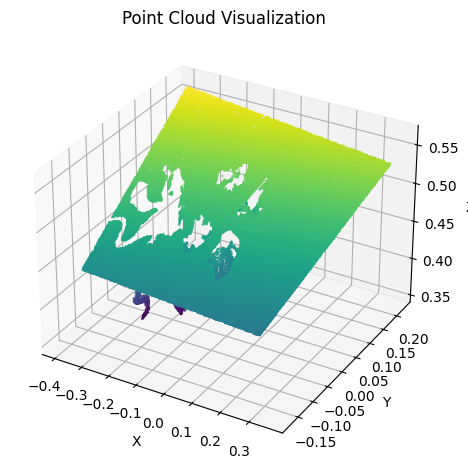

In [12]:
visualize_point_cloud(cloud)

In [13]:
ckpt_path = os.path.join(BASE_DIR, "experiments/exp_gripper_ours/ckpt/DexGraspNet2.0-ckpts/OURS_gripper/ckpt/ckpt_50000.pth")
model, config = load_grasp_model(ckpt_path)

In [14]:
cloud_vis, grasp = sample_grasp(model, cloud, config.data.voxel_size)
best_grasp = get_best_grasp(grasp)

In [15]:
trans = np.dot(np.load(os.path.join(scene_path, 'cam0_wrt_table.npy')), 
               np.load(os.path.join(scene_path, 'camera_poses.npy'))[view_id])

best_grasp_np = transform_grasp_to_world(best_grasp[0], trans)
# transform pc to world coordinates
cloud_vis = transform_pc(cloud_vis, trans)
visualize_grasp_plotly_with_box(cloud_vis, best_grasp_np)


In [9]:
# visualize_grasp_plotly_with_box(cloud_vis, best_grasp[0].detach().cpu().numpy())